# Training a Classifier based on deep learning

Codes in this notebook are executed on a Linux-based virtual machine with the following **computational requirements**:
* GPU:  RTX2080 Super
* vCPU:  8 
* CPU Memory: 48GB 
* GPU Memory: 8GB

## Import necessary dependencies and data

In [1]:
import os
import tensorflow as tf
from keras_tuner import Hyperband
import numpy as np
from transformers import TFDistilBertForSequenceClassification # DistilBERT with Classification Head
import keras_tuner
from tensorflow.keras.models import Model  # tf.keras, not standalone keras
import matplotlib.pyplot as plt

c:\Data\Canada\Study\masters\CSI 5386 - Natural Language Processing\Natural-Language-Processing\project-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = os.path.realpath(os.path.join(os.path.dirname(os.curdir), '..', 'data'))
DATASET_PATH = os.path.join(DATA_ROOT, 'Numpy Data')
X_train = np.load(os.path.join(DATASET_PATH, 'Text', 'X_train_text.npy'))
X_val = np.load(os.path.join(DATASET_PATH, 'Text', 'X_val_text.npy'))
X_test = np.load(os.path.join(DATASET_PATH, 'Text', 'X_test_text.npy'))
y_train = np.load(os.path.join(DATASET_PATH, 'y_train_text.npy'))
y_val = np.load(os.path.join(DATASET_PATH, 'y_val_text.npy'))

In [3]:
# Inspect the data
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (9851, 3, 768)
X_val shape: (100, 3, 768)
X_test shape: (18679, 3, 768)
y_train shape: (9851,)
y_val shape: (100,)


## Load the Pre-Trained DistilBERT Classification-based Model

In [4]:
# Load a pretrained model
# https://huggingface.co/distilbert/distilbert-base-uncased

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.trainable = True

# Convert y_train to a tensor
y_train_tensor = tf.convert_to_tensor(y_train)

# Model Description
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# Define the directory path
dir = os.path.dirname(os.curdir)

# Save the pretrained model
model.save(os.path.join(dir, 'models', 'model_2_deep_learning_distilBERT_pretrained'))


INFO:tensorflow:Assets written to: models\model_2_deep_learning_distilBERT_pretrained\assets


INFO:tensorflow:Assets written to: models\model_2_deep_learning_distilBERT_pretrained\assets


## Fine-tuning the DistilBERT Model

In [6]:
def build_model(hp):
    input_layer = tf.keras.Input(shape=(3, 768), name="embedding_input")

    # You can experiment with other architectures here (CNN, GRU, etc.)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=hp.Int("lstm_units", min_value=64, max_value=256, step=64),
            return_sequences=False
        )
    )(input_layer)

    x = tf.keras.layers.Dropout(
        rate=hp.Float("dropout", 0.1, 0.5, step=0.1)
    )(x)

    x = tf.keras.layers.Dense(
        units=hp.Int("dense_units", 32, 256, step=32),
        activation="relu"
    )(x)

    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-5, 1e-3, sampling="LOG")
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [7]:
# Hyperparameter Tuning
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='models',
    project_name='model_2_deep_learning_distilBERT_pretrained_tuned'
)

# Monkey patch to bypass incompatible Keras model check - to specify using tf.Keras instead of standalone Keras
def patched_validate_trial_model(self, model):
    if not isinstance(model, Model):
        print("⚠️ Model is not tf.keras.Model — bypassing check anyway")
        return
    return

keras_tuner.engine.trial.Trial._validate_trial_model = patched_validate_trial_model


tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Trial 30 Complete [00h 00m 18s]
val_accuracy: 0.9700000286102295

Best val_accuracy So Far: 0.9700000286102295
Total elapsed time: 00h 09m 49s


In [8]:
# Record the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

In [9]:
# Rebuild the model with the best hyperparameters
model = build_model(best_hp)

In [10]:
# Retrain
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
history

Epoch 1/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6443 - loss: 0.6131 - val_accuracy: 0.9700 - val_loss: 0.1608
Epoch 2/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8554 - loss: 0.3569 - val_accuracy: 0.9500 - val_loss: 0.1604
Epoch 3/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8786 - loss: 0.3055 - val_accuracy: 0.9400 - val_loss: 0.1539
Epoch 4/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8909 - loss: 0.2845 - val_accuracy: 0.9500 - val_loss: 0.1495
Epoch 5/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8919 - loss: 0.2710 - val_accuracy: 0.9400 - val_loss: 0.1661
Epoch 6/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8992 - loss: 0.2569 - val_accuracy: 0.9400 - val_loss: 0.1662
Epoch 7/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9022 - loss: 0.2470 - val_accuracy: 0.9300 - val_loss: 0.2288
Epoch 8/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8979 - loss: 0.2493 - val_accu

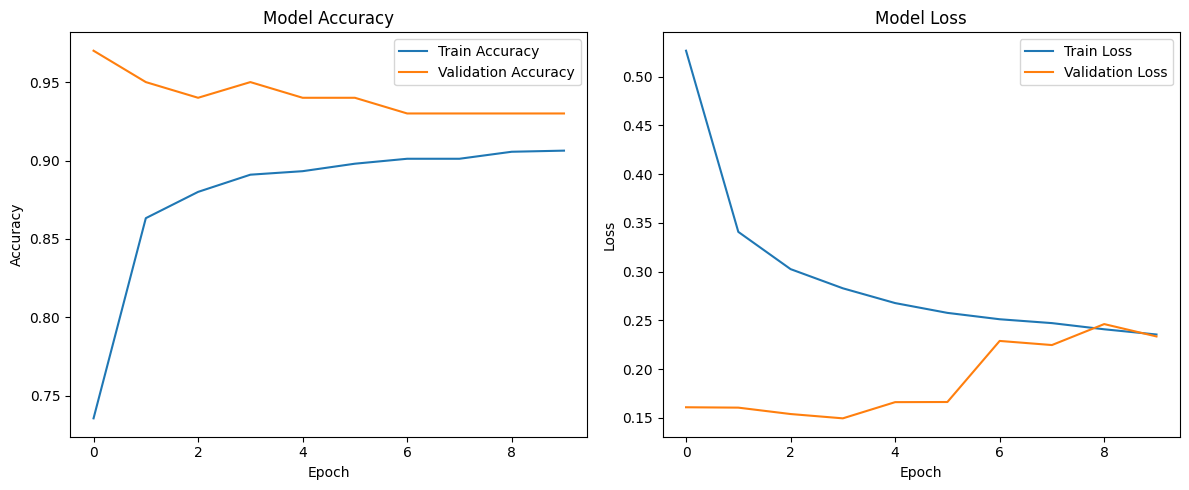

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Save Model
model.save(os.path.join(os.curdir, 'models', 'model_2_deep_learning_distilBERT_pretrained_tuned.h5'))